# Random Forest
Code changes.
Sort the RF feature importances.
Continue to force the aligner to choose one parent (change ties to guesses),
but show the Random Forest the aligner's output (including ties i.e. -1, 0, +1).
Use Brassica transcripts, bowtie.

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-06 13:27:55.173632


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/Models/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/BAM_ML/"
    MODEL_DIR="/Users/jasonmiller/WVU/BAM_ML/Models/"
SAVE_MODEL_FILENAME = None

GPU device not found
Running on CoLab
Mounted at /content/drive/


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150
IS_PARENT_2 = 45 # feature 45 holds aligner's choice for parent

Python 3.10.12
sklearn 1.2.2


## Data Load

In [4]:
MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM
#MAX_LINES_TO_LOAD =    10000 # use this for debugging

VALID_PORTION = 0.20

DATA_FILE_0 = 'Brassica/Bowtie/oleracea/read_stats.csv.gz'
DATA_FILE_1 = 'Brassica/Bowtie/rapa/read_stats.csv.gz'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)

Data directory: /content/drive/My Drive/data/IRP2/
Data file 0 Brassica/Bowtie/oleracea/read_stats.csv.gz
Data file 1 Brassica/Bowtie/rapa/read_stats.csv.gz
Input lines for training: 1000000


In [5]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS',
    'P1 R1 ED',
    'P1 R1 MM',
    'P1 R1 HQMM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R1 HQINS',
    'P1 R1 HQDEL',
    'P1 R2 AS',
    'P1 R2 ED',
    'P1 R2 MM',
    'P1 R2 HQMM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P1 R2 HQINS',
    'P1 R2 HQDEL',
    'P2 R1 AS',
    'P2 R1 ED',
    'P2 R1 MM',
    'P2 R1 HQMM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R1 HQINS',
    'P2 R1 HQDEL',
    'P2 R2 AS',
    'P2 R2 ED',
    'P2 R2 MM',
    'P2 R2 HQMM',
    'P2 R2 GO',
    'P2 R2 GE',
    'P2 R2 HQINS',
    'P2 R2 HQDEL',
    'R1 length',
    'R2 length',
    'P1 span',
    'P2 span',
    'Span diff',
    'AS diff',
    'ED diff',
    'MM diff',
    'HQMM diff',
    'GO diff',
    'GE diff',
    'HQINS diff',
    'HQDEL diff',
    'PARENT']
print('Total feature names: ',len(feature_names))
for i in range(len(feature_names)):
    print(i,feature_names[i])

Total feature names:  46
0 P1 R1 AS
1 P1 R1 ED
2 P1 R1 MM
3 P1 R1 HQMM
4 P1 R1 GO
5 P1 R1 GE
6 P1 R1 HQINS
7 P1 R1 HQDEL
8 P1 R2 AS
9 P1 R2 ED
10 P1 R2 MM
11 P1 R2 HQMM
12 P1 R2 GO
13 P1 R2 GE
14 P1 R2 HQINS
15 P1 R2 HQDEL
16 P2 R1 AS
17 P2 R1 ED
18 P2 R1 MM
19 P2 R1 HQMM
20 P2 R1 GO
21 P2 R1 GE
22 P2 R1 HQINS
23 P2 R1 HQDEL
24 P2 R2 AS
25 P2 R2 ED
26 P2 R2 MM
27 P2 R2 HQMM
28 P2 R2 GO
29 P2 R2 GE
30 P2 R2 HQINS
31 P2 R2 HQDEL
32 R1 length
33 R2 length
34 P1 span
35 P2 span
36 Span diff
37 AS diff
38 ED diff
39 MM diff
40 HQMM diff
41 GO diff
42 GE diff
43 HQINS diff
44 HQDEL diff
45 PARENT


In [6]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.verbose = verbose
        self.max_lines = None
        self.ties = 0
        self.predictions = []

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum

    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * 46
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 AS = Parent 1, Read 1, Alignment Score
        ints[0] = int(fields[0]) # P1 R1 AS
        ints[1] = int(fields[1]) # P1 R1 ED
        ints[2] = int(fields[2]) # P1 R1 MM
        ints[3] = int(fields[3]) # P1 R1 HQMM
        ints[4] = int(fields[4]) # P1 R1 GO
        ints[5] = int(fields[5]) # P1 R1 GE
        ints[6] = int(fields[6]) # P1 R1 HQINS
        ints[7] = int(fields[7]) # P1 R1 HQDEL
        ints[8] = int(fields[8]) # P1 R2 AS
        ints[9] = int(fields[9]) # P1 R2 ED
        ints[10] = int(fields[10]) # P1 R2 MM
        ints[11] = int(fields[11]) # P1 R2 HQMM
        ints[12] = int(fields[12]) # P1 R2 GO
        ints[13] = int(fields[13]) # P1 R2 GE
        ints[14] = int(fields[14]) # P1 R2 HQINS
        ints[15] = int(fields[15]) # P1 R2 HQDEL
        ints[16] = int(fields[16]) # P2 R1 AS
        ints[17] = int(fields[17]) # P2 R1 ED
        ints[18] = int(fields[18]) # P2 R1 MM
        ints[19] = int(fields[19]) # P2 R1 HQMM
        ints[20] = int(fields[20]) # P2 R1 GO
        ints[21] = int(fields[21]) # P2 R1 GE
        ints[22] = int(fields[22]) # P2 R1 HQINS
        ints[23] = int(fields[23]) # P2 R1 HQDEL
        ints[24] = int(fields[24]) # P2 R2 AS
        ints[25] = int(fields[25]) # P2 R2 ED
        ints[26] = int(fields[26]) # P2 R2 MM
        ints[27] = int(fields[27]) # P2 R2 HQMM
        ints[28] = int(fields[28]) # P2 R2 GO
        ints[29] = int(fields[29]) # P2 R2 GE
        ints[30] = int(fields[30]) # P2 R2 HQINS
        ints[31] = int(fields[31]) # P2 R2 HQDEL
        ints[32] = int(fields[32]) # R1 length
        ints[33] = int(fields[33]) # R2 length
        ints[34] = int(fields[34]) # P1 span
        ints[35] = int(fields[35]) # P2 span
        # We compute these 'diff' fields from the input data.
        ints[36] = int(ints[35]-ints[34]) # P2-P1 span diff
        ints[37] = int(((ints[16]+ints[24])-(ints[0]+ints[8]))/2) # AS diff
        ints[38] = int(((ints[17]+ints[25])-(ints[1]+ints[9]))/2) # ED diff
        ints[39] = int(((ints[18]+ints[26])-(ints[2]+ints[10]))/2) # MM diff
        ints[40] = int(((ints[19]+ints[27])-(ints[3]+ints[11]))/2) # HQMM diff
        ints[41] = int(((ints[20]+ints[28])-(ints[4]+ints[12]))/2) # GO diff
        ints[42] = int(((ints[21]+ints[29])-(ints[5]+ints[13]))/2) # GE diff
        ints[43] = int(((ints[22]+ints[30])-(ints[6]+ints[14]))/2) # HQINS diff
        ints[44] = int(((ints[23]+ints[31])-(ints[7]+ints[15]))/2) # HQDEL diff
        # The feature-extraction program populated fields[36]
        # to indicate which parent had higher alignment score.
        # Values were 0=same, 1=parent1, 2=parent2.
        # We change the values to -1=parent1, 0=unknown, +1=parent2
        parent_choice = int(fields[36])
        if parent_choice == 1:
            ints[45] = -1  # not parent 2
        elif parent_choice == 2:
            ints[45] = 1  # is parent 2
        elif parent_choice == 0:
            ints[45] = 0
        else:
            raise Exception('Unrecognized parent choice:'+str(parent_choice))
        # For fair comparison, force aligner to choose.
        # We change 1 to 0, 2 to 1, and 0 to 1 or 2 randomly.
        # TO DO: faster alternative to list.append() ???
        parent_choice = int(fields[36])
        if parent_choice == 1:
            self.predictions.append(0)  # not parent 2
        elif parent_choice == 2:
            self.predictions.append(1)  # is parent 2
        else: # parent_choice == 0:
            self.ties += 1
            guess = random.randint(0,1)
            self.predictions.append(guess)
        # The span of this read pair along either parent.
        # The transcript (in both parents) that this read pair aligned to.
        # An upstream filter removes cases of different transcript per parent.
        transcript_id = fields[36] # TO DO: where to put this?
        self.alignments.append(ints)

    def count_ties(self):
        return self.ties

    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0)
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            print('Most likely, one file has too few reads.')
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL')
            print(self.alignments[i][0:8])
            print(self.alignments[i][8:16])
            print(self.alignments[i][16:24])
            print(self.alignments[i][24:32])

    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

    def get_predictions(self):
        loaded = len(self.predictions)
        divider = int(loaded - loaded * VALID_PORTION)
        y_train = self.predictions[:divider]
        y_valid = self.predictions[divider:]
        return y_train, y_valid

In [7]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING')
loader.load_full_train_set()
print('Number of ties: %d' % loader.count_ties())
aligner_predictions_train, aligner_predictions_valid = loader.get_predictions()
print(datetime.now())
loader.show_examples()

2023-07-06 13:28:20.204811
Maximum lines to load per file: 1000000
LOADING
Trying to load 1000000 lines per file...
Number of ties: 63323
2023-07-06 13:28:53.429371
From /content/drive/My Drive/data/IRP2/Brassica/Bowtie/oleracea/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-25, 6, 5, 2, 1, 1, 0, 0]
[-9, 3, 3, 0, 0, 0, 0, 0]
[-57, 15, 12, 4, 1, 3, 3, 0]
[-60, 17, 8, 2, 1, 9, 7, 0]
From /content/drive/My Drive/data/IRP2/Brassica/Bowtie/rapa/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-90, 17, 12, 12, 3, 5, 4, 1]
[-89, 22, 10, 8, 1, 12, 12, 0]
[-70, 13, 8, 8, 3, 5, 4, 1]
[-69, 18, 6, 4, 1, 12, 12, 0]
From /content/drive/My Drive/data/IRP2/Brassica/Bowtie/oleracea/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[-31, 7, 7, 6, 0, 0, 0, 0]
[-25, 5, 5, 5, 0, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/Brassica/Bowtie/rapa/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExte

In [8]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print('X[5]=')
print(X_train[5])
print('y[5]=')
print(y_train[5])
#loader = None

Full train set size = 2000000
Training/Validation partition: 1600000/400000
X train shape: 
(1600000, 46)
y train shape: 
(1600000,)
X valid shape: 
(400000, 46)
y valid shape: 
(400000,)
X[5]=
[-54  11  11  10   0   0   0   0 -80  16  14  13   1   2   2   0   0   0
   0   0   0   0   0   0 -58  17   1   1   1  16  16   0 149 150 194 180
 -14  38  -5 -12 -11   0   7   7   0   1]
y[5]=
1


## Model

In [9]:
def build_model():
    rfc = RFC()
    return rfc

In [10]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-07-06 13:29:04.413304
RandomForestClassifier()


## Training

In [11]:
print(datetime.now())
print("FIT")
rfc_model.fit(X_train, y_train) # sample weight
print(datetime.now())

2023-07-06 13:29:04.428370
FIT
2023-07-06 13:36:34.718295


## Validation

In [12]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-06 13:36:34.731284
PREDICT
debug pred [0.0, 0.30104761904761895, 0.01]
debug class [0 0 0]
2023-07-06 13:37:11.080890


In [13]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [14]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.5001255635793028 mean 0.46052581271911236 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[186451  13549]
 [ 11913 188087]]
Normalized matrix
 [[0.4661275 0.0338725]
 [0.0297825 0.4702175]]
Predictions:  {0: 198364, 1: 201636}
Accuracy: 93.63% F1: 93.66% MCC: 0.8727
Precision: 93.28% Recall: 94.04% AUPRC: 98.21%
Sensitivity: 94.04% Specificity: 93.23% AUROC: 98.21%


## Comparison

In [15]:
show_performance(y_valid, aligner_predictions_valid, None)

Predictions:  {0: 210522, 1: 189478}
Accuracy: 91.55% F1: 91.32% MCC: 0.8321
Precision: 93.85% Recall: 88.91% AUPRC: 0.00%
Sensitivity: 88.91% Specificity: 94.18% AUROC: 0.00%


## Feature Importance

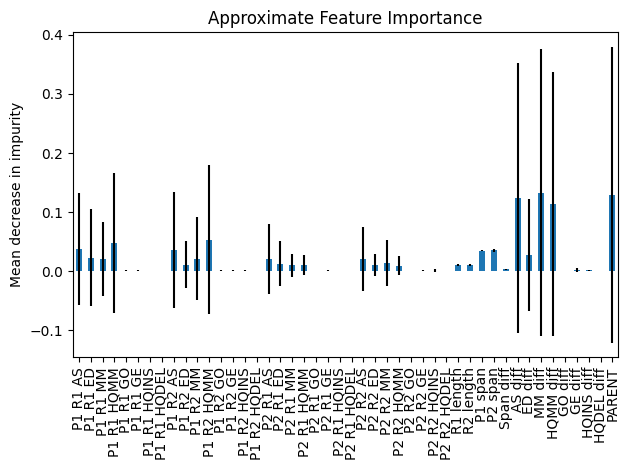

In [16]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
print(forest_importances)

P1 R1 AS       0.037863
P1 R1 ED       0.023067
P1 R1 MM       0.019894
P1 R1 HQMM     0.047826
P1 R1 GO       0.000721
P1 R1 GE       0.001180
P1 R1 HQINS    0.000893
P1 R1 HQDEL    0.000350
P1 R2 AS       0.035657
P1 R2 ED       0.011189
P1 R2 MM       0.021240
P1 R2 HQMM     0.053222
P1 R2 GO       0.000741
P1 R2 GE       0.001083
P1 R2 HQINS    0.000953
P1 R2 HQDEL    0.000386
P2 R1 AS       0.020587
P2 R1 ED       0.013048
P2 R1 MM       0.010329
P2 R1 HQMM     0.010830
P2 R1 GO       0.000602
P2 R1 GE       0.001145
P2 R1 HQINS    0.000951
P2 R1 HQDEL    0.000383
P2 R2 AS       0.020939
P2 R2 ED       0.010637
P2 R2 MM       0.013645
P2 R2 HQMM     0.009323
P2 R2 GO       0.000646
P2 R2 GE       0.001174
P2 R2 HQINS    0.001189
P2 R2 HQDEL    0.000372
R1 length      0.010543
R2 length      0.010628
P1 span        0.034910
P2 span        0.035344
Span diff      0.003125
AS diff        0.124409
ED diff        0.027504
MM diff        0.132957
HQMM diff      0.114261
GO diff        0

In [18]:
forest_importances.sort_values()

GO diff        0.000308
P1 R1 HQDEL    0.000350
P2 R2 HQDEL    0.000372
P2 R1 HQDEL    0.000383
P1 R2 HQDEL    0.000386
P2 R1 GO       0.000602
P2 R2 GO       0.000646
P1 R1 GO       0.000721
P1 R2 GO       0.000741
HQDEL diff     0.000778
P1 R1 HQINS    0.000893
P2 R1 HQINS    0.000951
P1 R2 HQINS    0.000953
P1 R2 GE       0.001083
P2 R1 GE       0.001145
P2 R2 GE       0.001174
P1 R1 GE       0.001180
P2 R2 HQINS    0.001189
HQINS diff     0.001725
GE diff        0.002096
Span diff      0.003125
P2 R2 HQMM     0.009323
P2 R1 MM       0.010329
R1 length      0.010543
R2 length      0.010628
P2 R2 ED       0.010637
P2 R1 HQMM     0.010830
P1 R2 ED       0.011189
P2 R1 ED       0.013048
P2 R2 MM       0.013645
P1 R1 MM       0.019894
P2 R1 AS       0.020587
P2 R2 AS       0.020939
P1 R2 MM       0.021240
P1 R1 ED       0.023067
ED diff        0.027504
P1 span        0.034910
P2 span        0.035344
P1 R2 AS       0.035657
P1 R1 AS       0.037863
P1 R1 HQMM     0.047826
P1 R2 HQMM     0